In [7]:
import numpy as np
import os
from scipy.signal import fftconvolve
from scipy.ndimage import gaussian_laplace
from scipy.fft import fftn, ifftn
import scipy.io as sio
import tifffile as tiff
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt


In [22]:
def make_LoG_filter(x, y, sig):
    """
    Create a Laplacian of Gaussian (LoG) filter using scipy's gaussian_laplace.
    
    Parameters:
    x, y: np.ndarray
        X and Y coordinates of the filter (produced by meshgrid).
    sig: float or list
        Sigma values for the LoG filter. Can be a single value or [gaussian axis, LoG axis].
    
    Returns:
    fil: np.ndarray
        Laplacian of Gaussian (LoG) filter.
    """
    if isinstance(sig, (int, float)):
        # For a single sigma value
        r = np.sqrt(x**2 + y**2)  # Radial distance
        return gaussian_laplace(r, sigma=sig)
    elif len(sig) == 2:
        # Applying gaussian_laplace separately along each axis
        return gaussian_laplace(x, sigma=sig[0]) * gaussian_laplace(y, sigma=sig[1])
    else:
        raise ValueError("Sigma should be a float or a list of length 2.")

        


def fft_LoG(filSig, numSig, numAngs, filterThreshold, im, stdThreshold):
    """
    Function to apply an FFT-based rotating Laplacian of Gaussian (LoG) filter.
    
    Parameters:
    filSig          : Sigma(s) for the LoG filter (related to size of fibers in the image)
    numSig          : Size of the filter as a multiple of filSig
    numAngs         : Number of angles for rotating the LoG filter
    filterThreshold : Threshold for binarizing the max projection of all filtered images
    im              : Input image
    stdThreshold    : Standard deviation threshold for mask filtering
    
    Returns:
    prefAng : Preferred angle for each pixel in the image.
    """

    # Create filter array
    ix, iy = np.meshgrid(
        np.linspace(-max(filSig) * numSig, max(filSig) * numSig, im.shape[0]),
        np.linspace(-max(filSig) * numSig, max(filSig) * numSig, im.shape[1])
    )
    
    filArray = np.zeros((ix.shape[0], iy.shape[1], numAngs))

    # Apply filters at different angles
    for i in tqdm(range(numAngs)):
        ang = np.pi * i / numAngs
        ix2 = np.cos(ang) * ix - np.sin(ang) * iy
        iy2 = np.sin(ang) * ix + np.cos(ang) * iy
        fil = make_LoG_filter(ix2, iy2, filSig)
        fil -= np.mean(fil)  # Subtract the mean to normalize the filter
        filArray[:, :, i] = fil

    filSize = filArray.shape

    # Pad the image and filter arrays using numpy's pad function
    padSize1 = (filSize[0] // 2, filSize[1] // 2)
    imArray = np.pad(im, pad_width=((padSize1[0], padSize1[0]), (padSize1[1], padSize1[1])), mode='constant', constant_values=np.mean(im))
    
    imSize = imArray.shape

    # Ensure proper padding size for filter array
    filArray = np.pad(filArray, ((0, imSize[0] - filSize[0]), (0, imSize[1] - filSize[1]), (0, 0)), mode='constant', constant_values=0)
    
    # Perform FFT on image and filters
    fftImArray = fftn(imArray)
    fftFilArray = fftn(filArray, axes=(0, 1))

    # Filtering
    filIm = ifftn(fftImArray[..., np.newaxis] * fftFilArray, axes=(0, 1))
    filIm = filIm[padSize1[0]:-padSize1[0], padSize1[1]:-padSize1[1], :]  # Crop the padded regions
    
    # Process the result
    mask = np.max(filIm, axis=2) > filterThreshold
    prefAngIm = np.argmax(filIm, axis=2)
    prefAng = prefAngIm.astype(float)
    prefAng[~mask] = np.nan  # Mask out regions below the threshold
    prefAng = np.pi * (prefAng - 1) / numAngs

    if stdThreshold > 0:
        stdIm = np.std(filIm, axis=2)
        stdMask = stdIm > stdThreshold
        prefAng[~stdMask] = np.nan

    # Remove boundary artifacts
    b = [filSize[0] // 2, filSize[1] // 2]
    prefAng[:b[0], :] = np.nan
    prefAng[-b[0]:, :] = np.nan
    prefAng[:, :b[1]] = np.nan
    prefAng[:, -b[1]:] = np.nan

    return prefAng



def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

In [35]:
import numpy as np
from scipy.ndimage import gaussian_laplace
from scipy.signal import fftconvolve
from tqdm import tqdm  # For progress bar

def make_LoG_filter(x, y, sig):
    """
    Create a Laplacian of Gaussian (LoG) filter using scipy's gaussian_laplace.
    
    Parameters:
    x, y: np.ndarray
        X and Y coordinates of the filter (produced by meshgrid).
    sig: float or list
        Sigma values for the LoG filter. Can be a single value or [gaussian axis, LoG axis].
    
    Returns:
    fil: np.ndarray
        Laplacian of Gaussian (LoG) filter.
    """
    if isinstance(sig, (int, float)):
        # For a single sigma value
        r = np.sqrt(x**2 + y**2)  # Radial distance
        return gaussian_laplace(r, sigma=sig)
    elif len(sig) == 2:
        # Applying gaussian_laplace separately along each axis
        return gaussian_laplace(x, sigma=sig[0]) * gaussian_laplace(y, sigma=sig[1])
    else:
        raise ValueError("Sigma should be a float or a list of length 2.")

def fft_LoG(filSig, numSig, numAngs, filterThreshold, im, stdThreshold):
    """
    Function to apply an FFT-based rotating Laplacian of Gaussian (LoG) filter.
    
    Parameters:
    filSig          : Sigma(s) for the LoG filter (related to size of fibers in the image)
    numSig          : Size of the filter as a multiple of filSig
    numAngs         : Number of angles for rotating the LoG filter
    filterThreshold : Threshold for binarizing the max projection of all filtered images
    im              : Input image
    stdThreshold    : Standard deviation threshold for mask filtering
    
    Returns:
    prefAng : Preferred angle for each pixel in the image.
    filtered_images : The filtered images for all angles.
    """

    # Create filter array
    ix, iy = np.meshgrid(
        np.linspace(-max(filSig) * numSig, max(filSig) * numSig, im.shape[0]),
        np.linspace(-max(filSig) * numSig, max(filSig) * numSig, im.shape[1])
    )
    
    filArray = np.zeros((ix.shape[0], iy.shape[1], numAngs))

    # Apply filters at different angles
    for i in tqdm(range(numAngs)):
        ang = np.pi * i / numAngs
        ix2 = np.cos(ang) * ix - np.sin(ang) * iy
        iy2 = np.sin(ang) * ix + np.cos(ang) * iy
        fil = make_LoG_filter(ix2, iy2, filSig)
        fil -= np.mean(fil)  # Subtract the mean to normalize the filter
        filArray[:, :, i] = fil

    # Create padded image
    padSize = filArray.shape[0] // 2
    imArray = np.pad(im, pad_width=((padSize, padSize), (padSize, padSize)), mode='constant', constant_values=np.mean(im))

    # Convolve image with filters using fftconvolve
    filtered_images = np.zeros((imArray.shape[0], imArray.shape[1], numAngs))

    for i in range(numAngs):
        filtered_images[:, :, i] = fftconvolve(imArray, filArray[:, :, i], mode='same')

    # Process the result
    mask = np.max(filtered_images, axis=2) > filterThreshold
    prefAngIm = np.argmax(filtered_images, axis=2)
    prefAng = prefAngIm.astype(float)
    prefAng[~mask] = np.nan  # Mask out regions below the threshold
    prefAng = np.pi * (prefAng - 1) / numAngs

    if stdThreshold > 0:
        stdIm = np.std(filtered_images, axis=2)
        stdMask = stdIm > stdThreshold
        prefAng[~stdMask] = np.nan

    # Remove boundary artifacts
    b = padSize
    prefAng[:b, :] = np.nan
    prefAng[-b:, :] = np.nan
    prefAng[:, :b] = np.nan
    prefAng[:, -b:] = np.nan

    return prefAng, filtered_images  # Return preferred angles and filtered images

def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")


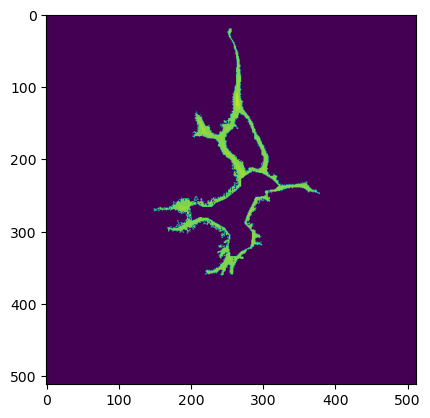

In [36]:
# Address where all raw images are
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2018_10_01_MAX_60X_B1_timelapse1');
file_name = 'control_div2_glass_2018_10_01_MAX_60X_B1_timelapse1_jttr_blch_corr.tiff'
resolution = 4.7619   #px./um
frame_interval = 5.0   #s/frame.

image_path = data_folder+'\\'+file_name
img = tiff.imread(image_path) 

# mask = sio.loadmat(data_folder +'\\cell_mask.mat')['binary_mask']   # if want to use the raw cell mask
mask = sio.loadmat(data_folder +'\\neural_mask.mat')['neural_mask']

mask = mask.astype(float)  # Convert the mask to float
mask[np.isnan(mask)] = 0   # Replace NaN values with 0

im_mean = np.mean(img,0)*mask
plt.imshow(im_mean)

In [37]:
preferred_angles, filtered_images = fft_LoG(filSig, numSig, numAngs, filterThreshold, im_mean, stdThreshold)


100%|██████████| 180/180 [00:03<00:00, 49.30it/s]


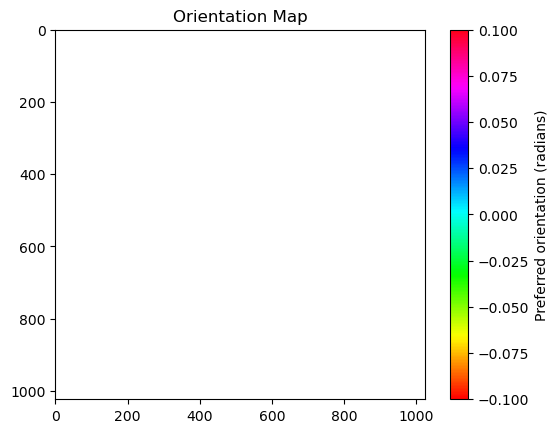

In [38]:
filSig = [1, 1]  
numSig = 1
numAngs = 180
filterThreshold = 2
stdThreshold = 0.2


# Apply fft_LoG to the image
# preferred_angles = fft_LoG(filSig, numSig, numAngs, filterThreshold, im_mean, stdThreshold)

# Step 4: Visualize the preferred orientation map
plt.imshow(preferred_angles, cmap='hsv')  # Use 'hsv' colormap to represent angles
plt.colorbar(label='Preferred orientation (radians)')
plt.title('Orientation Map')
plt.show()

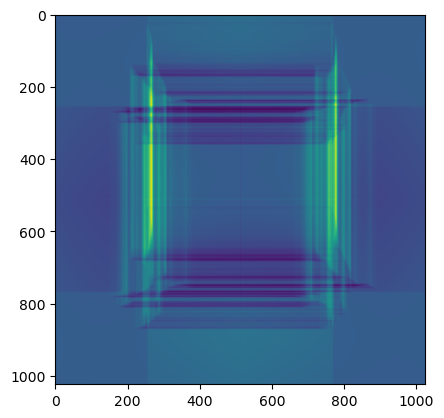

In [43]:
plt.imshow(filtered_images[:,:,50])

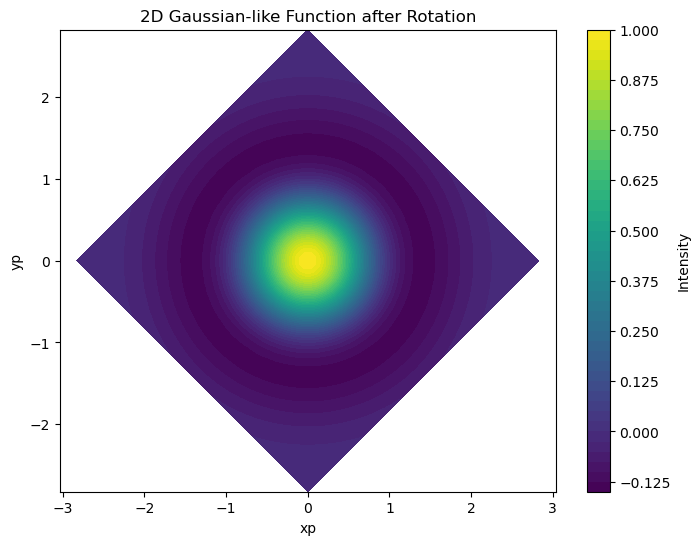

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D grid
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
x, y = np.meshgrid(x, y)

# Define the rotation angles (in radians)
theta = np.pi / 4  # For example, a 45-degree rotation
phi = 0  # No rotation around the z-axis since we're in 2D

# Rotate around the origin in 2D
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])

# Apply the rotation
xp = R[0, 0] * x + R[0, 1] * y
yp = R[1, 0] * x + R[1, 1] * y

# Define the 2D function
log_2d = (1 - xp**2 - yp**2) * np.exp(-xp**2 - yp**2)

# Plotting the result
plt.figure(figsize=(8, 6))
plt.contourf(xp, yp, log_2d, levels=50, cmap='viridis')
plt.colorbar(label='Intensity')
plt.title('2D Gaussian-like Function after Rotation')
plt.xlabel('xp')
plt.ylabel('yp')
plt.axis('equal')
plt.show()


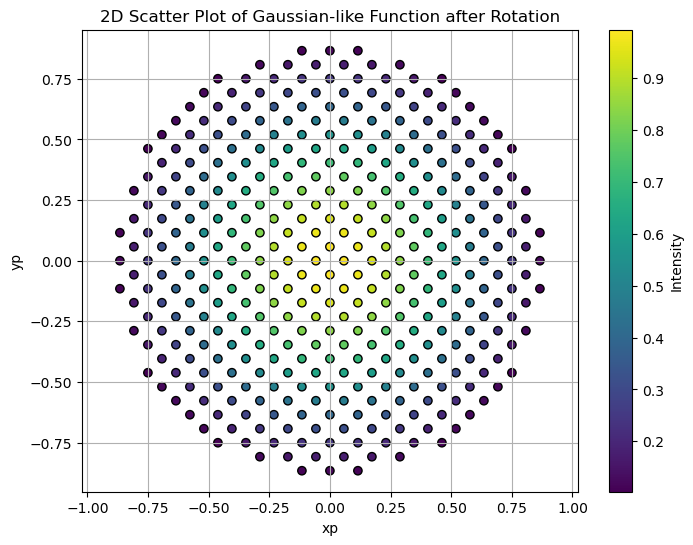

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D grid
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
x, y = np.meshgrid(x, y)

# Define the rotation angle (in radians)
theta = np.pi / 4  # For example, a 45-degree rotation

# Rotate around the origin in 2D
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])

# Apply the rotation
xp = R[0, 0] * x + R[0, 1] * y
yp = R[1, 0] * x + R[1, 1] * y

# Define the 2D function
log_2d = (1 - xp**2 - yp**2) * np.exp(-xp**2 - yp**2)

# Plotting the result as a 2D scatter plot
plt.figure(figsize=(8, 6))
thresh = 0.1  # Set a threshold for coloring the points
plt.scatter(xp[log_2d > thresh], yp[log_2d > thresh], 
            c=log_2d[log_2d > thresh], cmap='viridis', edgecolor='k')

plt.colorbar(label='Intensity')
plt.title('2D Scatter Plot of Gaussian-like Function after Rotation')
plt.xlabel('xp')
plt.ylabel('yp')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.axis('equal')
plt.grid()
plt.show()


In [46]:
out = fftconvolve(im_mean, log_2d, mode='same', axes=None)

In [47]:
np.shape(im_mean),np.shape(log_2d),np.shape(out)

((512, 512), (50, 50), (512, 512))

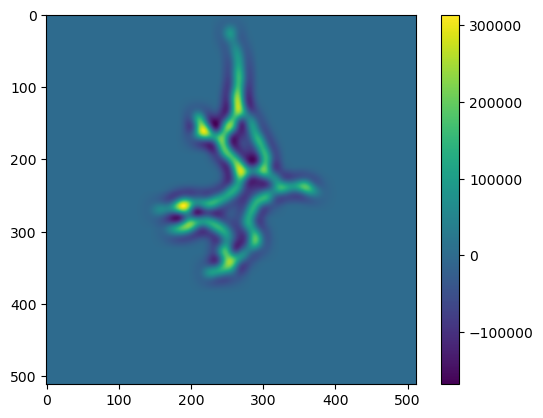

In [53]:
plt.imshow(out); plt.colorbar()